# 02 – Retention and Cohort Analysis

This notebook analyses customer retention and cohort behaviour for the SaaS company.
It uses the `monthly_activity` table to measure how many subscriptions remain active over time,
and how retention differs across cohorts and plan types.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Display settings
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)

# File paths
PROC_DIR = "data/processed"
monthly_path = os.path.join(PROC_DIR, "monthly_activity.csv")
plans_path = os.path.join(PROC_DIR, "plans.csv")

monthly_df = pd.read_csv(monthly_path, parse_dates=["month", "cohort_month"])
plans_df = pd.read_csv(plans_path)

monthly_df.head()


,subscription_id,customer_id,plan_id,month,cohort_month,is_active,is_new,churned_this_month,mrr_usd
0,1,5,4,2023-01-01,2023-01-01,True,True,False,24.92
1,1,5,4,2023-02-01,2023-01-01,True,False,False,24.92
2,1,5,4,2023-03-01,2023-01-01,True,False,False,24.92
3,1,5,4,2023-04-01,2023-01-01,True,False,False,24.92
4,1,5,4,2023-05-01,2023-01-01,True,False,False,24.92


## Cohort retention table

Calculate number of active subscriptions per cohort and month, and derive retention rates.



In [3]:
# Ensure cohort_month is month-start and create months_since_cohort
monthly_df["cohort_month"] = monthly_df["cohort_month"].dt.to_period("M").dt.to_timestamp()
monthly_df["activity_month"] = monthly_df["month"].dt.to_period("M").dt.to_timestamp()

monthly_df["months_since_cohort"] = (
    (monthly_df["activity_month"].dt.year - monthly_df["cohort_month"].dt.year) * 12
    + (monthly_df["activity_month"].dt.month - monthly_df["cohort_month"].dt.month)
)

# Cohort sizes (based on first active month per subscription)
cohort_sizes = (
    monthly_df[monthly_df["is_new"]]
    .groupby("cohort_month")["subscription_id"]
    .nunique()
    .rename("cohort_size")
    .reset_index()
)

cohort_activity = (
    monthly_df[monthly_df["is_active"]]
    .groupby(["cohort_month", "months_since_cohort"])["subscription_id"]
    .nunique()
    .rename("active_subscriptions")
    .reset_index()
)

cohort_retention = cohort_activity.merge(cohort_sizes, on="cohort_month", how="left")
cohort_retention["retention_rate"] = (
    cohort_retention["active_subscriptions"] / cohort_retention["cohort_size"]
)

cohort_retention.head()


,cohort_month,months_since_cohort,active_subscriptions,cohort_size,retention_rate
0,2022-01-01,0,10,13,0.769231
1,2022-01-01,1,10,13,0.769231
2,2022-01-01,2,9,13,0.692308
3,2022-01-01,3,8,13,0.615385
4,2022-01-01,4,7,13,0.538462


## Retention heatmap

Retention rate (%) by cohort (rows) and months since cohort (columns).


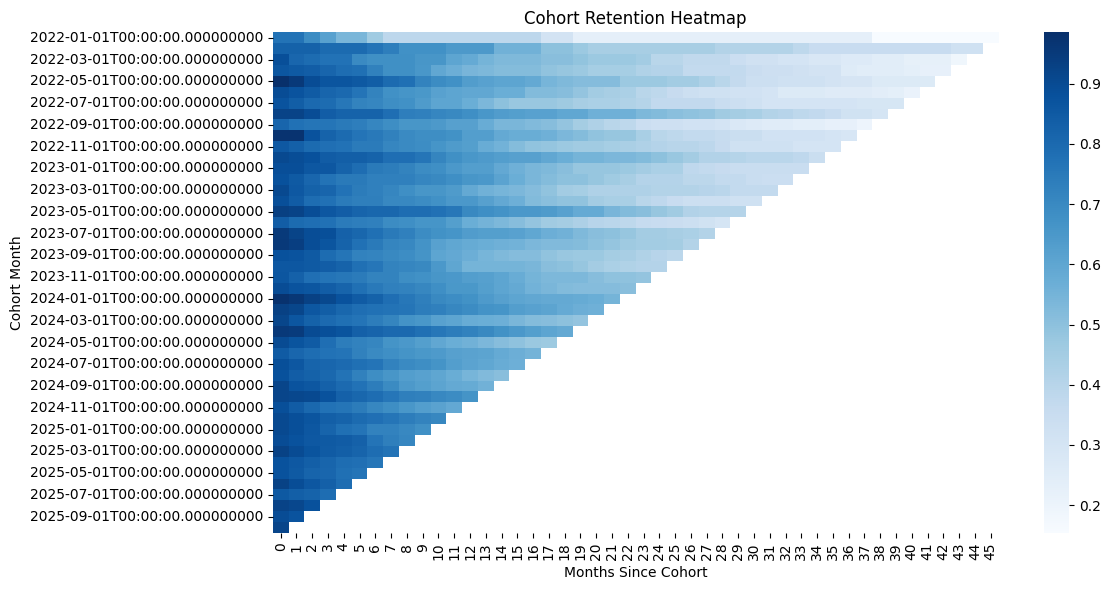

In [4]:
# Pivot to matrix form: cohorts as rows, months_since_cohort as columns
heatmap_data = cohort_retention.pivot_table(
    index="cohort_month",
    columns="months_since_cohort",
    values="retention_rate"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=False,
    fmt=".0%",
    cmap="Blues"
)
plt.title("Cohort Retention Heatmap")
plt.xlabel("Months Since Cohort")
plt.ylabel("Cohort Month")
plt.tight_layout()
plt.show()


## Retention curves for selected cohorts


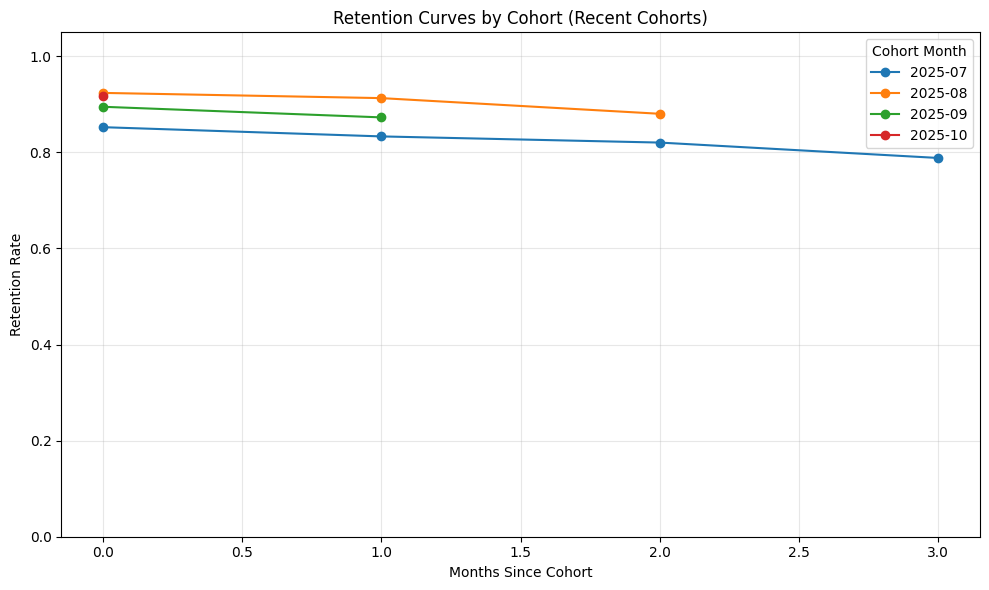

In [5]:
# Choose a few recent cohorts to plot
recent_cohorts = (
    cohort_retention["cohort_month"]
    .drop_duplicates()
    .sort_values()
    .tail(4)
    .tolist()
)

plt.figure(figsize=(10, 6))

for c in recent_cohorts:
    subset = cohort_retention[cohort_retention["cohort_month"] == c]
    plt.plot(
        subset["months_since_cohort"],
        subset["retention_rate"],
        marker="o",
        label=c.strftime("%Y-%m")
    )

plt.title("Retention Curves by Cohort (Recent Cohorts)")
plt.xlabel("Months Since Cohort")
plt.ylabel("Retention Rate")
plt.ylim(0, 1.05)
plt.legend(title="Cohort Month")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Retention comparison by billing period

Compare retention for monthly vs annual plans.


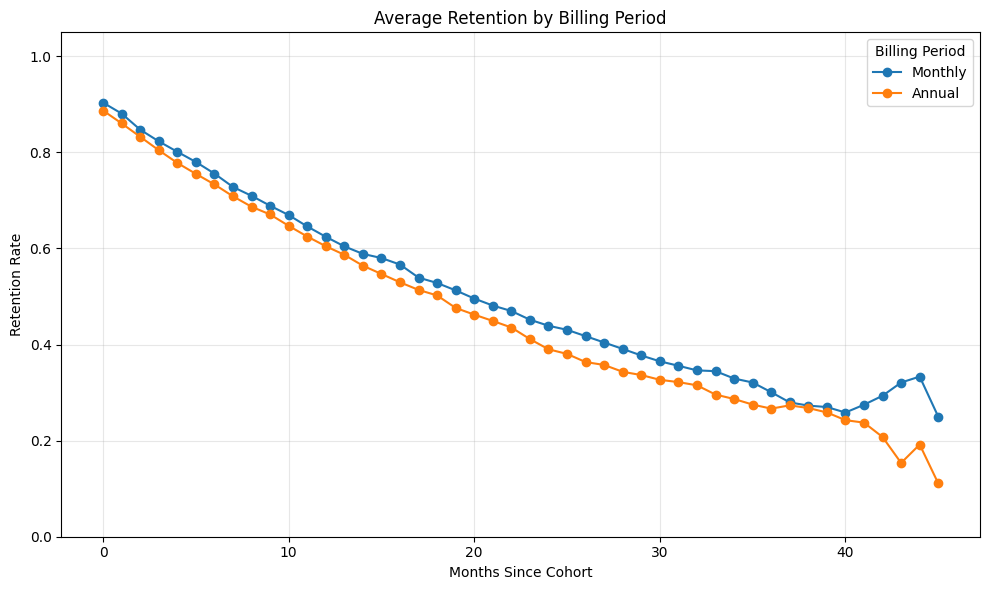

In [6]:
# Merge plan info into monthly activity
monthly_with_plans = monthly_df.merge(plans_df[["plan_id", "billing_period"]], on="plan_id", how="left")

# Cohort retention by billing_period
cohort_activity_bp = (
    monthly_with_plans[monthly_with_plans["is_active"]]
    .groupby(["billing_period", "cohort_month", "months_since_cohort"])["subscription_id"]
    .nunique()
    .rename("active_subscriptions")
    .reset_index()
)

cohort_sizes_bp = (
    monthly_with_plans[monthly_with_plans["is_new"]]
    .groupby(["billing_period", "cohort_month"])["subscription_id"]
    .nunique()
    .rename("cohort_size")
    .reset_index()
)

cohort_retention_bp = cohort_activity_bp.merge(
    cohort_sizes_bp,
    on=["billing_period", "cohort_month"],
    how="left"
)
cohort_retention_bp["retention_rate"] = (
    cohort_retention_bp["active_subscriptions"] / cohort_retention_bp["cohort_size"]
)

# Average retention by months_since_cohort and billing_period
avg_retention_bp = (
    cohort_retention_bp
    .groupby(["billing_period", "months_since_cohort"])["retention_rate"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))

for bp in ["monthly", "annual"]:
    sub = avg_retention_bp[avg_retention_bp["billing_period"] == bp]
    plt.plot(
        sub["months_since_cohort"],
        sub["retention_rate"],
        marker="o",
        label=bp.capitalize()
    )

plt.title("Average Retention by Billing Period")
plt.xlabel("Months Since Cohort")
plt.ylabel("Retention Rate")
plt.ylim(0, 1.05)
plt.legend(title="Billing Period")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
